# STPB_LSTM_WITH_CLASS

In [1936]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1937]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [1938]:
import statsmodels.api as sm
import statslib as stb
import tensorflow as tf
import seaborn as sns

In [1939]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset

In [1940]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [1941]:
from gmt.fom.gas.shared.models.short_term_power_burn.stpb import MongoAdapter

In [1942]:
figsize=(9*1.6, 9)

In [1943]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [1944]:
def get_fourier_series(timeIndex,K):
    m = 7
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.RangeIndex(1,len(timeIndex)+1))

    for i in range(1, K+1):
        fourier_series[f'S{i}-{m}'] = np.sin(2 * i * np.pi * d *fourier_series.index/ m)
        fourier_series[f'C{i}-{m}'] = np.cos(2 * i * np.pi * d *fourier_series.index/ m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = timeIndex
    return fourier_series

# CONSTANTS

In [1945]:
YEARS = 4

In [1946]:
FORECAST_HORIZON = 1; FORECAST_HORIZON

1

In [1947]:
INPUT_WIDTH = 50; INPUT_WIDTH 

50

# DATA

In [1948]:
myData = MongoAdapter()
data = myData.load_design_matrix()

In [1949]:
#<------- TRAIN --------- VALIDATION -------- TEST -------->

In [1950]:
train_up_to_idx = data.index.min() + DateOffset(years=YEARS)
train_idx = data.truncate(after=train_up_to_idx).index

In [1951]:
pred_idx = data[-(2*INPUT_WIDTH+FORECAST_HORIZON):-FORECAST_HORIZON].index

In [1952]:
out_t_idx = data[-FORECAST_HORIZON:].index

In [1953]:
val_idx = sorted(set(data.index).difference(set(train_idx).union(pred_idx).union(out_t_idx)))

In [1954]:
print(f'train_idx={len(train_idx)}\nval_idx={len(val_idx)}\npred_idx={len(pred_idx)}\nout_t_idx={len(out_t_idx)}')

train_idx=1462
val_idx=307
pred_idx=100
out_t_idx=1


In [1955]:
assert len(train_idx)+len(val_idx)+len(pred_idx)+len(out_t_idx)==data.shape[0]

In [1956]:
#Enrich for Design Matrix

In [1957]:
#fourier series
K = 3
data = data.join(get_fourier_series(data.index,K))

In [1958]:
dependent_var = ['gas']; dependent_var
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind']
fourier_cols =  [k for k in data if k.startswith('S') or k.startswith('C')]

In [1959]:
y = data[dependent_var]; f = stb.transforms.identical();
gs = dict()
g1 = stb.transforms.identical();
gs.update(dict(zip(covariates, [g1]*len(covariates))))
g2 = stb.transforms.identical()
gs.update(dict(zip(fourier_cols, [g2]*len(fourier_cols))))
X = data[covariates  + fourier_cols ]; 

In [1960]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=False)

In [1961]:
train_df = DM.dm.loc[train_idx].drop('y', axis=1).rename(columns=DM.names)
val_df = DM.dm.loc[val_idx].drop('y', axis=1).rename(columns=DM.names)
pred_df =DM.dm.loc[pred_idx].drop('y', axis=1).rename(columns=DM.names)
out_df =DM.dm.loc[out_t_idx].drop('y', axis=1).rename(columns=DM.names)

In [1962]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
pred_df = (pred_df - train_mean) / train_std

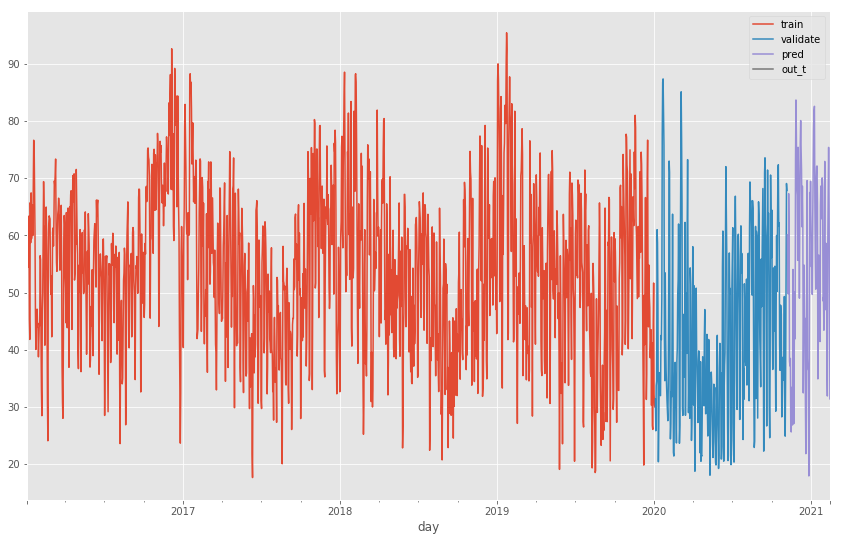

In [1963]:
fig, ax = plt.subplots(figsize=figsize)
DM.y.loc[train_idx].plot(ax=ax)
DM.y.loc[val_idx].plot(ax=ax)
DM.y.loc[pred_idx].plot(ax=ax)
DM.y.loc[out_t_idx].plot(ax=ax)
plt.legend(['train', 'validate', 'pred', 'out_t'])
plt.show()

# STANDARDIZATION OF FEATURES

In [1964]:
train_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2020-01-03,-1.697426,-0.271198,-1.159558,-0.518133,-0.679771,0.980831,-1.104921,0.882715,-1.377814,-0.313725,-0.613185,-1.273196


In [1965]:
val_df.head(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
t,,,,,,,,,,,,
2020-01-04,-1.599593,-0.271198,-1.159558,-0.764528,-0.753444,0.37391,5.872145e-14,1.415182,1.153151e-13,1.415182,-1.464933e-13,1.415182


In [1966]:
val_df.tail(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
t,,,,,,,,,,,,
2020-11-05,0.998194,1.07068,0.483457,-0.854557,-0.438918,-0.831384,-1.377814,-0.313725,0.613185,-1.273196,1.104921,0.882715


In [1967]:
pred_df.head(1)

,gas,clean_spreads,dark_spreads,precip,temperature,wind,S1-7,C1-7,S2-7,C2-7,S3-7,C3-7
day,,,,,,,,,,,,
2020-11-06,0.445451,1.07068,0.483457,-0.868772,-0.525814,-0.831384,-1.104921,0.882715,-1.377814,-0.313725,-0.613185,-1.273196


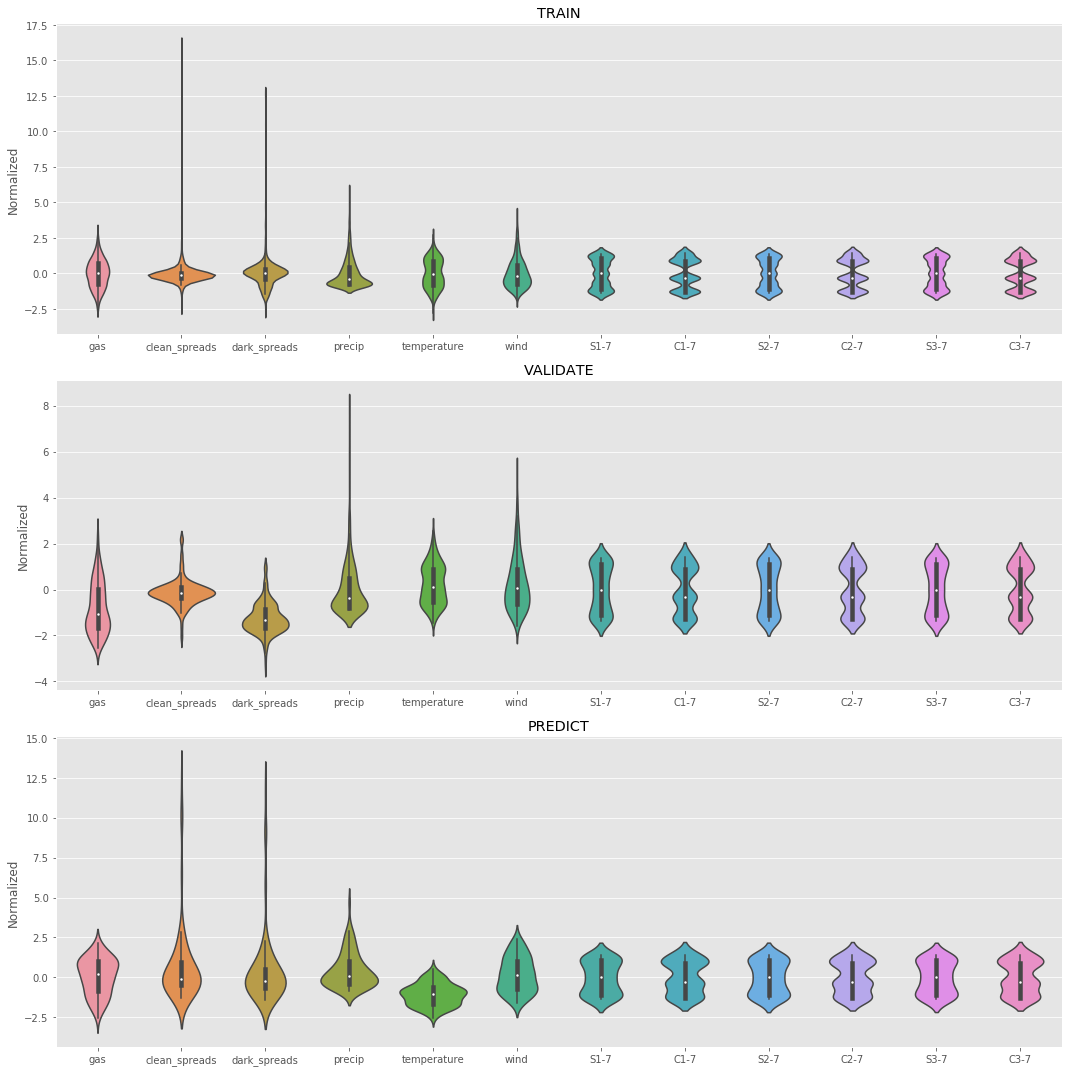

In [1968]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
_ = train_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax1)
_ = val_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax2)
_ = pred_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax3)
ax1.set_title('TRAIN')
ax2.set_title('VALIDATE')
ax3.set_title('PREDICT')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
plt.tight_layout()
plt.show()

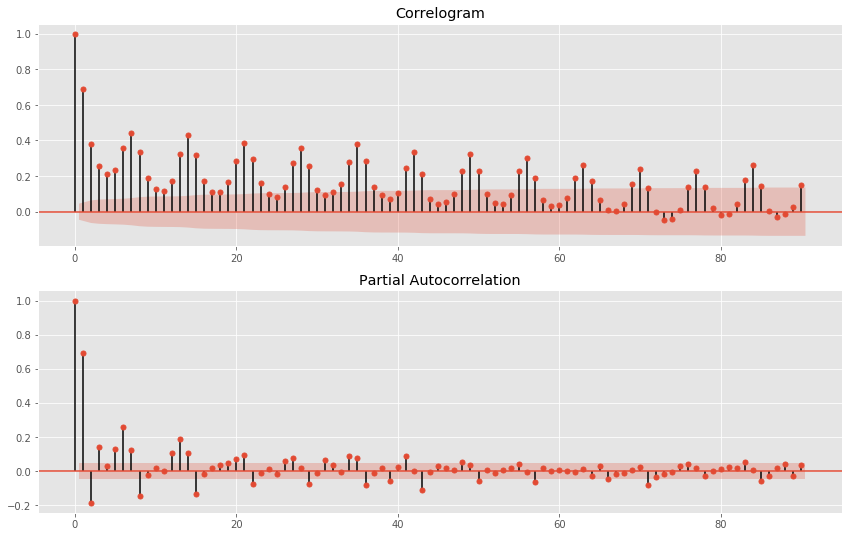

In [1969]:
stb.stat_plots.plot_acf_pcf(y, kwargs_acf=dict(lags=90), kwargs_pacf=dict(lags=90))

# WINDOWS GENERATOR

In [1970]:
INP_W = 7*3
OUT_W = 7
BATC_S = 1
SHUFFLE = False

In [1971]:
window = stb.WindowGenerator(
                         input_width=INP_W,
                         label_width=OUT_W,
                         shift=OUT_W,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=pred_df,
                         label_columns=['gas'])

In [1972]:
window

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label indices: [21 22 23 24 25 26 27]
Label column name(s): ['gas']

In [1973]:
window.config(shuffle=SHUFFLE, batch_size=BATC_S)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 1}


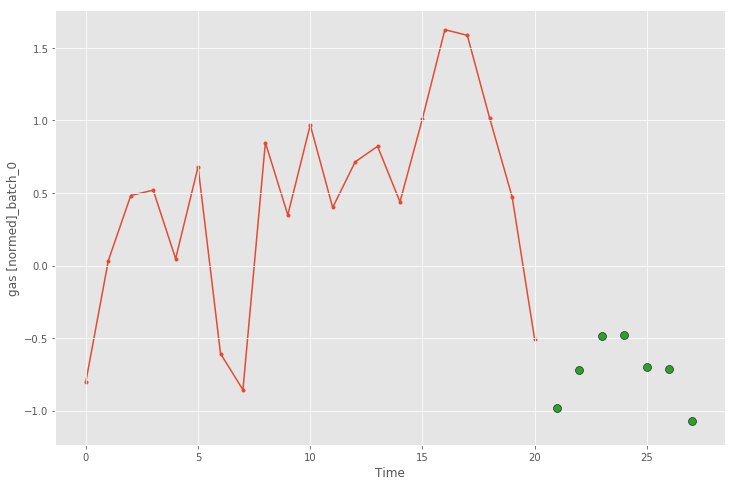

In [1974]:
window.plot('gas')

# Long Short Term Memory RNN

In [1975]:
lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(units=64, activation='relu',return_sequences=True),
    tf.keras.layers.LSTM(units=64, activation='relu',return_sequences=False),
    tf.keras.layers.Dense(units=OUT_W)
])

In [1976]:
print('Input shape (batch_size, input_days, num_features):', window.example[0].shape)
print('Output shape (batch_size, output_days):', lstm_model(window.example[0]).shape)

Input shape (batch_size, input_days, num_features): (1, 21, 12)
Output shape (batch_size, output_days): (1, 7)


In [1977]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=4, learning_rate=5e-3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=learning_rate),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, 
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [1978]:
history = compile_and_fit(lstm_model,window)

Epoch 1/200
1435/1435 [==============================] - 13s 8ms/step - loss: 1.1662 - mean_squared_error: 1.1662 - val_loss: 1.6064 - val_mean_squared_error: 1.6064
Epoch 2/200
1435/1435 [==============================] - 12s 8ms/step - loss: 0.8285 - mean_squared_error: 0.8285 - val_loss: 1.5998 - val_mean_squared_error: 1.5998
Epoch 3/200
1435/1435 [==============================] - 13s 9ms/step - loss: 337204.1651 - mean_squared_error: 337204.1651 - val_loss: 1.7081 - val_mean_squared_error: 1.7081
Epoch 4/200
1435/1435 [==============================] - 13s 9ms/step - loss: 1.0345 - mean_squared_error: 1.0345 - val_loss: 1.4443 - val_mean_squared_error: 1.4443
Epoch 5/200
1435/1435 [==============================] - 12s 9ms/step - loss: 0.7178 - mean_squared_error: 0.7178 - val_loss: 1.4284 - val_mean_squared_error: 1.4284
Epoch 6/200
1435/1435 [==============================] - 12s 9ms/step - loss: 1.2213 - mean_squared_error: 1.2213 - val_loss: 1.2932 - val_mean_squared_error: 1

2021-04-07 08:44:43,147: tensorflow: 126: WARNING: 5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001CDE6D23048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details..


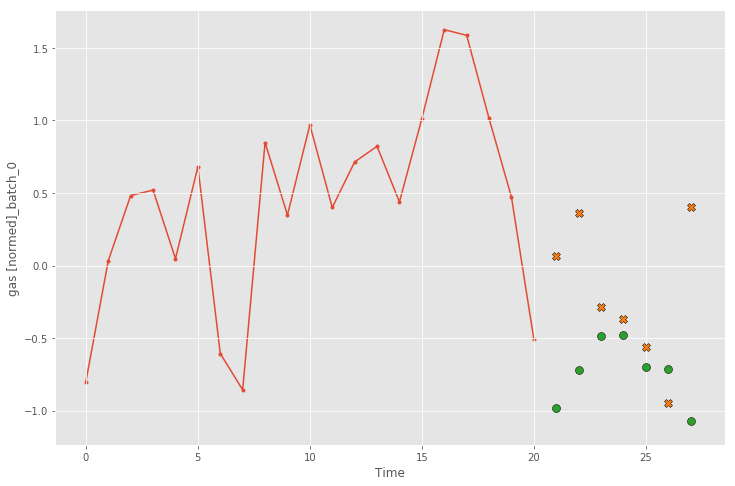

In [1979]:
res = window.plot('gas', model=lstm_model)

In [1980]:
w_pred = stb.WindowGenerator(
            input_width=INP_W,
            label_width=0,
            shift=0,
            train_df=pred_df.head(INP_W),
            val_df=None,
            test_df=None,
            label_columns=['gas'])

w_pred.config(shuffle=False, batch_size=1)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 1}


In [1981]:
fl(lstm_model.predict(w_pred.train))

2021-04-07 08:44:44,058: tensorflow: 126: WARNING: 6 out of the last 12 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001CDE6D23048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details..


[2.1352942,
 -0.69350004,
 -1.4152609,
 -2.1170702,
 -1.18022,
 -0.18183163,
 -1.3933629]

In [1982]:
fl = stb.utils.common.flatten_lst

In [1983]:
idx = pred_df.shift(INP_W).dropna().head(OUT_W).index; idx

DatetimeIndex(['2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03'],
              dtype='datetime64[ns]', name='day', freq=None)

In [1984]:
predicted = fl(lstm_model.predict(w_pred.train)); predicted

[2.1352942,
 -0.69350004,
 -1.4152609,
 -2.1170702,
 -1.18022,
 -0.18183163,
 -1.3933629]

In [1985]:
v_hat = pd.Series(predicted, index=idx); v_hat

day
2020-11-27    2.135294
2020-11-28   -0.693500
2020-11-29   -1.415261
2020-11-30   -2.117070
2020-12-01   -1.180220
2020-12-02   -0.181832
2020-12-03   -1.393363
dtype: float64

In [1986]:
v = pred_df.loc[idx]['gas']; v

day
2020-11-27    1.679879
2020-11-28    1.025967
2020-11-29    0.938618
2020-11-30    0.128224
2020-12-01    1.536395
2020-12-02    1.172624
2020-12-03    1.001891
Name: gas, dtype: float64

In [1987]:
y_hat = v_hat*train_std['gas']+train_mean['gas']; y_hat

day
2020-11-27    83.835233
2020-11-28    44.114524
2020-11-29    33.979869
2020-11-30    24.125365
2020-12-01    37.280212
2020-12-02    51.299151
2020-12-03    34.287352
dtype: float64

In [1988]:
y = DM.dm.loc[y_hat.index]['y']; y

day
2020-11-27    77.440494
2020-11-28    68.258536
2020-11-29    67.032024
2020-11-30    55.652825
2020-12-01    75.425746
2020-12-02    70.317838
2020-12-03    67.920476
Name: y, dtype: float64

In [1989]:
print(f'Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')

Error=28.4309


In [1990]:
metric = stb.metrics.root_mean_squared_error

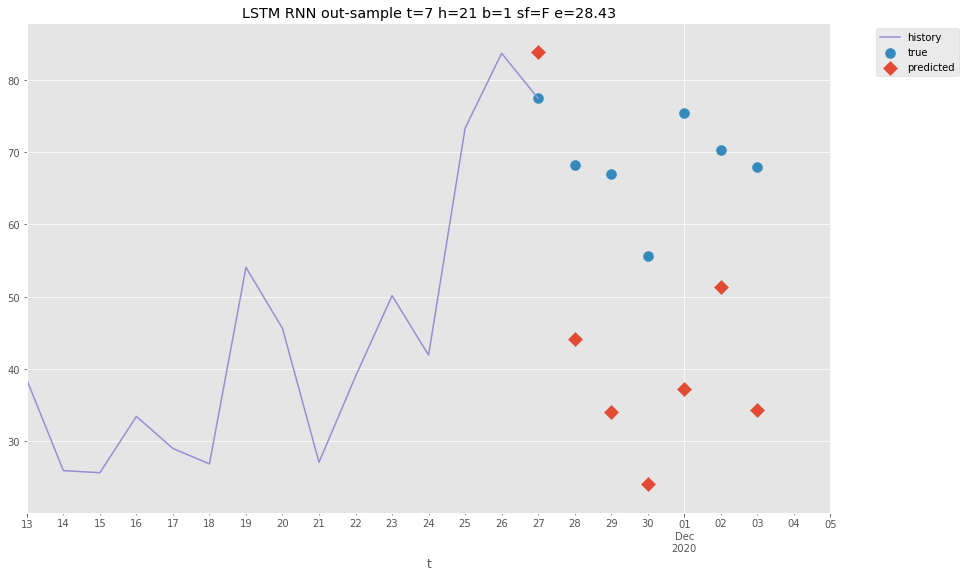

In [1991]:
out_of_sample_error = metric(y, y_hat)

fig, ax =plt.subplots(figsize=figsize)
DM.dm.truncate(after=y_hat.index.min()).iloc[-int(15):]['v'].plot(ax=ax, 
                                        color=stb.utils.plots.get_standard_colors()[2])
# y.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[1])
# y_hat.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[0])

ax.scatter(y.index, y.values, 100, color=stb.utils.plots.get_standard_colors()[1])
ax.scatter(y_hat.index, y_hat.values, 100, marker='D', color=stb.utils.plots.get_standard_colors()[0])


ax.legend(['history', 'true', 'predicted'], bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(right=y.index.max() + DateOffset(days=2))

plt.title(f'ForecastHorizon={OUT_W}days | Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')
title = f'LSTM RNN out-sample t={OUT_W} h={INP_W} b={BATC_S} sf={str(SHUFFLE)[0]} e={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()